Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install .. # installing d2l


# Network in Network (NiN)
:label:`sec_nin`

LeNet, AlexNet e VGG compartilham um padrão de design comum:
extrair recursos que exploram a estrutura *espacial*
por meio de uma sequência de camadas de convolução e agrupamento
e, em seguida, pós-processar as representações por meio de camadas totalmente conectadas.
As melhorias no LeNet por AlexNet e VGG residem principalmente
em como essas redes posteriores ampliam e aprofundam esses dois módulos.
Alternativamente, pode-se imaginar o uso de camadas totalmente conectadas
no início do processo.
No entanto, um uso descuidado de camadas densas pode desistir da
estrutura espacial da representação inteiramente,
Os blocos *rede em rede* (*NiN*) oferecem uma alternativa.
Eles foram propostos com base em uma visão muito simples:
para usar um MLP nos canais para cada pixel separadamente :cite:`Lin.Chen.Yan.2013`.


## Blocos NiN 

Lembre-se de que as entradas e saídas das camadas convolucionais
consistem em tensores quadridimensionais com eixos
correspondendo ao exemplo, canal, altura e largura.
Lembre-se também de que as entradas e saídas de camadas totalmente conectadas
são tipicamente tensores bidimensionais correspondentes ao exemplo e ao recurso.
A ideia por trás do NiN é aplicar uma camada totalmente conectada
em cada localização de pixel (para cada altura e largura).
Se amarrarmos os pesos em cada localização espacial,
poderíamos pensar nisso como uma camada convolucional $1 \times 1$
(conforme descrito em :numref:`sec_channels`)
ou como uma camada totalmente conectada agindo de forma independente em cada localização de pixel.
Outra maneira de ver isso é pensar em cada elemento na dimensão espacial
(altura e largura) como equivalente a um exemplo
e um canal como equivalente a um recurso.

:numref:`fig_nin` ilustra as principais diferenças estruturais
entre VGG e NiN, e seus blocos.
O bloco NiN consiste em uma camada convolucional
seguido por duas camadas convolucionais $1 \times 1$ que atuam como
camadas totalmente conectadas por pixel com ativações ReLU.
A forma da janela de convolução da primeira camada é normalmente definida pelo usuário.
As formas de janela subsequentes são fixadas em $1 \times 1$.

![Comparando arquiteturas de VGG e NiN, e seus blocos.](../img/nin.svg)
:width:`600px`
:label:`fig_nin`


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

## Modelo NiN 

A rede NiN original foi proposta logo após AlexNet
e claramente tira alguma inspiração.
NiN usa camadas convolucionais com formas de janela
de $11\times 11$, $5\times 5$ e $3\times 3$,
e os números correspondentes de canais de saída são iguais aos do AlexNet. Cada bloco NiN é seguido por uma camada de *pooling* máxima
com um passo de 2 e uma forma de janela de $3\times 3$.

Uma diferença significativa entre NiN e AlexNet
é que o NiN evita camadas totalmente conectadas.
Em vez disso, NiN usa um bloco NiN com um número de canais de saída igual ao número de classes de rótulo, seguido por uma camada de *pooling* média global,
produzindo um vetor de logits.
Uma vantagem do design da NiN é que
reduz o número de parâmetros de modelo necessários.
No entanto, na prática, esse design às vezes requer
aumento do tempo de treinamento do modelo.


In [2]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # Há 3 classes de rótulos
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # Transforme a saída quadridimensional em saída bidimensional com uma forma de (batch size, 10)
    nn.Flatten())

Criamos um exemplo de dados para ver a forma de saída de cada bloco.


In [3]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


## Treinamento

Como antes, usamos o Fashion-MNIST para treinar a modelo.
O treinamento de NiN é semelhante ao de AlexNet e VGG.


loss 0.359, train acc 0.865, test acc 0.860
3201.6 examples/sec on cuda:0


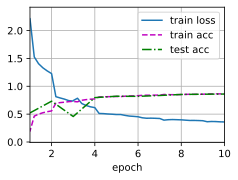

In [4]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Sumário

* NiN usa blocos que consistem em uma camada convolucional e várias camadas convolucionais $1\times 1$. Isso pode ser usado dentro da pilha convolucional para permitir mais não linearidade por pixel.
* NiN remove as camadas totalmente conectadas e as substitui pelo agrupamento médio global (ou seja, somando todos os locais) depois de reduzir o número de canais para o número desejado de saídas (por exemplo, 10 para Fashion-MNIST).
* A remoção das camadas totalmente conectadas reduz o ajuste excessivo. NiN tem muito menos parâmetros.
* O design NiN influenciou muitos designs subsequentes da CNN.

## Exercícios

1. Ajuste os hiperparâmetros para melhorar a precisão da classificação.
2. Por que existem duas camadas convolucionais $1\times 1$ no bloco NiN? Remova um deles e então observe e analise os fenômenos experimentais.
3. Calcule o uso de recursos para NiN.
     1. Qual é o número de parâmetros?
     1. Qual é a quantidade de computação?
     1. Qual é a quantidade de memória necessária durante o treinamento?
     1. Qual é a quantidade de memória necessária durante a previsão?
4. Quais são os possíveis problemas com a redução da representação $384 \times 5 \times 5$ para uma representação $10 \times 5 \times 5$ em uma etapa?


[Discussão](https://discuss.d2l.ai/t/80)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMTA4MjAwMDYxNiwxNDE3MDk3MTM5LDMxOD
U2OTc2NywtMTc1MDkzODQ4NywyMDA0NTE0ODJdfQ==
-->
